# Computational Time Analysis

Here we do a time analysis for clustering and reinforcement learning. We use pycaret to do this analysis and conclude that the time required for clustering will not be a problem.

In [16]:
import numpy as np
import pandas as pd
import rioxarray as rxr
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from skimage.transform import rescale, downscale_local_mean
from pycaret.classification import *
from pycaret.clustering import *
import time

In [17]:
# Path to your working directory to store the images
data_path = "/Users/tthomas/Desktop/ESS569/MLGEO2024_MarsFans/data/ai_ready/" # This is an example, change it to your own path

blendDEM = rxr.open_rasterio(data_path + "blendDEM_aiready.tif", cache=False)
blendSLOPE = rxr.open_rasterio(data_path + "blendSLOPE_aiready.tif", cache=False)

ctxDEM = rxr.open_rasterio(data_path + "ctxDEM_aiready.tif", cache=False)
ctxIMG = rxr.open_rasterio(data_path + "ctxIMG_aiready.tif", cache=False)
ctxSLOPE = rxr.open_rasterio(data_path + "ctxSLOPE_aiready.tif", cache=False)

dayIR = rxr.open_rasterio(data_path + "dayIR_aiready.tif", cache=False)
nightIR = rxr.open_rasterio(data_path + "nightIR_aiready.tif", cache=False)

hrscND = rxr.open_rasterio(data_path + "hrscND_aiready.tif", cache=False)
hrscP1 = rxr.open_rasterio(data_path + "hrscP1_aiready.tif", cache=False)
hrscP2 = rxr.open_rasterio(data_path + "hrscP2_aiready.tif", cache=False)
hrscS1 = rxr.open_rasterio(data_path + "hrscS1_aiready.tif", cache=False)
hrscS2 = rxr.open_rasterio(data_path + "hrscS2_aiready.tif", cache=False)

training_imgs = [blendDEM, blendSLOPE, ctxDEM, ctxIMG, ctxSLOPE, dayIR, nightIR, hrscND, hrscP1, hrscP2, hrscS1, hrscS2]
training_names = ['blendDEM', 'blendSLOPE', 'ctxDEM', 'ctxIMG', 'ctxSLOPE', 'dayIR', 'nightIR', 'hrscND', 'hrscP1', 'hrscP2', 'hrscS1', 'hrscS2']

label_map = rxr.open_rasterio("/Users/tthomas/Desktop/ESS569/MLGEO2024_MarsFans/data/label/validation_map.tif", cache=False)

# Time analysis for clustering algorithms

,Description,Value
0,Session id,3720
1,Original data shape,"(40000, 10)"
2,Transformed data shape,"(40000, 10)"
3,Numeric features,10
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,CPU Jobs,-1
9,Use GPU,False


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4003,14884.7154,1.1277,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2895,16068.6640,1.2054,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2742,15560.5771,1.2520,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2701,13766.0203,1.3137,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2400,13733.9612,1.2744,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2129,12630.2915,1.3697,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2195,11668.1881,1.3610,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2281,11533.2402,1.3503,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2310,11062.8913,1.3009,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2289,10460.6908,1.3479,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2290,9814.7549,1.3695,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2121,9440.4992,1.3936,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2097,9030.3143,1.3862,0,0,0


    Number of Clusters  Training Time (Sec)
0                    2            14.989398
1                    3            14.350120
2                    4            13.215177
3                    5            13.268040
4                    6            12.828288
5                    7            12.632384
6                    8            12.833290
7                    9            12.682597
8                   10            12.659746
9                   11            12.518460
10                  12            12.413895
11                  13            12.384361
12                  14            12.098143


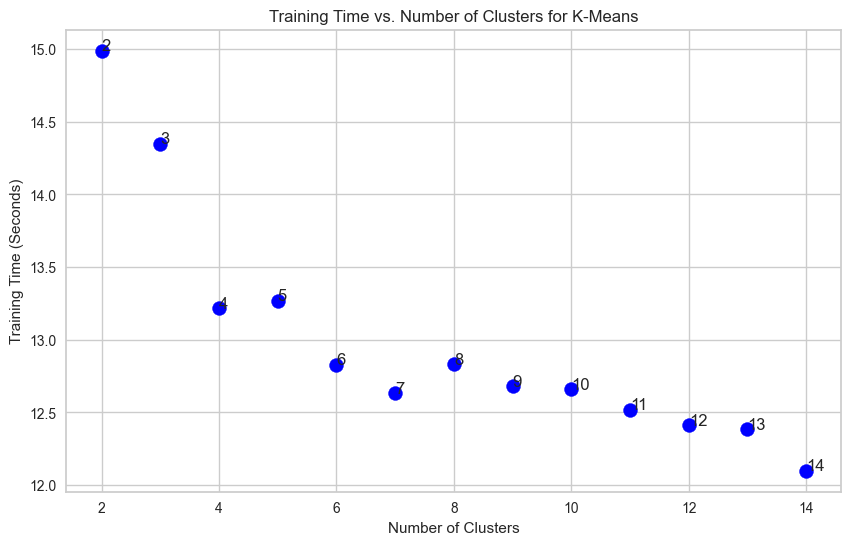

In [25]:
# Combine the images into a multi-band image
subset_imgs = [blendDEM, blendSLOPE, ctxDEM, ctxIMG, ctxSLOPE, hrscND, hrscP1, hrscP2, hrscS1, hrscS2]
multi_band_image = np.stack([img.values[0] for img in subset_imgs], axis=-1)

# Flatten the multi-band image into a 2D array where each row represents a pixel and each column represents a band
pixels = multi_band_image.reshape(-1, multi_band_image.shape[-1])

# Convert to a DataFrame
df = pd.DataFrame(pixels, columns=[f'band_{i+1}' for i in range(multi_band_image.shape[-1])])
subset_size = 40000  # Adjust this size based on the desired subset size
df_subset = df.sample(n=subset_size, random_state=0)

# Initialize the PyCaret environment for clustering
clustering_setup = setup(data=df_subset)

# List to store results
results = []

# List of number of clusters to test
num_clusters_list = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

for num_clusters in num_clusters_list:
    # Measure training time
    start_time = time.time()
    kmeans_model = create_model('kmeans', num_clusters=num_clusters)
    end_time = time.time()
    training_time = end_time - start_time
    
    # Evaluate the K-Means model
    # evaluate_model(kmeans_model)
    
    # Store the results
    results.append({'Number of Clusters': num_clusters, 'Training Time (Sec)': training_time})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Print the results
print(results_df)

# Create a scatter plot for training time vs. number of clusters
plt.figure(figsize=(10, 6))
plt.scatter(results_df['Number of Clusters'], results_df['Training Time (Sec)'], color='blue', s=100)

# Annotate the points with the number of clusters
for i, num_clusters in enumerate(results_df['Number of Clusters']):
    plt.annotate(num_clusters, (results_df['Number of Clusters'][i], results_df['Training Time (Sec)'][i]), fontsize=12)

plt.xlabel('Number of Clusters')
plt.ylabel('Training Time (Seconds)')
plt.title('Training Time vs. Number of Clusters for K-Means')
plt.grid(True)
plt.show()

It looks like after 6 clusters, training time is very similar which is great considering 6-12 is the range we are targeting. This training was done with PyCaret with a subset of our data, but full trainings have already been done locally with sci-kit learn with the entire dataset. This indicates that time won't be an issue moving forward.

# Time analysis for reinforcement learning

First, downsample the image so training can be done at a reasonable speed.

In [ ]:
# Downsample factor
downsample_factor = 0.1  # Adjust this factor based on the desired downsampling

# Function to downsample an image
def downsample_image(image, factor):
    return rescale(image.values[0], factor, anti_aliasing=True)

# Function to downsample a label map while maintaining discrete values
def downsample_label_map(label_map, factor):
    block_size = int(1 / factor)
    downsampled = downscale_local_mean(label_map.values[0], (block_size, block_size))
    return np.round(downsampled).astype(label_map.values.dtype)

# Downsample the images
subset_imgs = [blendDEM, blendSLOPE, ctxDEM, ctxIMG, ctxSLOPE, hrscND, hrscP1, hrscP2, hrscS1, hrscS2]
downsampled_imgs = [downsample_image(img, downsample_factor) for img in subset_imgs]

# Downsample the label map
downsampled_label_map = downsample_label_map(label_map, downsample_factor)

# Ensure the dimensions match by trimming the larger dimension
min_shape = (min(downsampled_label_map.shape[0], downsampled_imgs[0].shape[0]),
             min(downsampled_label_map.shape[1], downsampled_imgs[0].shape[1]))

downsampled_label_map = downsampled_label_map[:min_shape[0], :min_shape[1]]
downsampled_imgs = [img[:min_shape[0], :min_shape[1]] for img in downsampled_imgs]

# Combine the downsampled images into a multi-band image
downsampled_multi_band_image = np.stack(downsampled_imgs, axis=-1)

# Convert the downsampled images and label map back to xarray DataArray
# downsampled_imgs_xr = [rxr.DataArray(img, dims=("y", "x")) for img in downsampled_imgs]
# downsampled_label_map_xr = rxr.DataArray(downsampled_label_map, dims=("y", "x"))

print("Dimensions of downsampled_label_map:", downsampled_label_map.shape, downsampled_label_map.size)
print("Dimensions of downsampled_multi_band_image:", downsampled_multi_band_image.shape, downsampled_multi_band_image.size)

# Flatten the multi-band image into a 2D array where each row represents a pixel and each column represents a band
pixels = downsampled_multi_band_image.reshape(-1, downsampled_multi_band_image.shape[-1])
labels = downsampled_label_map.ravel()

# Convert to a DataFrame
df = pd.DataFrame(pixels, columns=[f'band_{i+1}' for i in range(downsampled_multi_band_image.shape[-1])])
df['label'] = labels

# Remove pixels with no label (assuming no label is represented by a specific value, e.g., -1)
# df = df[df['label'] != -1]

# Split the data into training and testing sets
X = df.drop(columns=['label'])
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Dictionary to store accuracy results
accuracy_results = {}

Try a range of different training models with PyCaret

In [4]:
s = setup(data=df, target='label')
best = compare_models()

,Description,Value
0,Session id,4289
1,Target,label
2,Target type,Multiclass
3,Original data shape,"(87535, 11)"
4,Transformed data shape,"(87535, 11)"
5,Transformed train set shape,"(61274, 11)"
6,Transformed test set shape,"(26261, 11)"
7,Numeric features,10
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8323,0.9679,0.8323,0.8319,0.8291,0.7533,0.7541,0.6000
rf,Random Forest Classifier,0.8260,0.9663,0.8260,0.8250,0.8230,0.7443,0.7449,1.8910
lightgbm,Light Gradient Boosting Machine,0.7937,0.9555,0.7937,0.7928,0.7925,0.6986,0.6989,3.5500
knn,K Neighbors Classifier,0.7709,0.9295,0.7709,0.7671,0.7668,0.6624,0.6630,0.0750
dt,Decision Tree Classifier,0.7547,0.8345,0.7547,0.7553,0.7549,0.6444,0.6444,0.1110
gbc,Gradient Boosting Classifier,0.7308,0.0000,0.7308,0.7287,0.7259,0.6036,0.6050,14.4870
qda,Quadratic Discriminant Analysis,0.6482,0.0000,0.6482,0.6757,0.6572,0.5063,0.5092,0.0160
nb,Naive Bayes,0.5916,0.8577,0.5916,0.6434,0.6097,0.4370,0.4414,0.0140
lda,Linear Discriminant Analysis,0.5703,0.0000,0.5703,0.5319,0.5311,0.3263,0.3383,0.0150
lr,Logistic Regression,0.5678,0.0000,0.5678,0.5335,0.5261,0.3182,0.3316,0.3880


                                    Model  Accuracy     AUC  Recall   Prec.  \
et                 Extra Trees Classifier    0.8323  0.9679  0.8323  0.8319   
rf               Random Forest Classifier    0.8260  0.9663  0.8260  0.8250   
lightgbm  Light Gradient Boosting Machine    0.7937  0.9555  0.7937  0.7928   
knn                K Neighbors Classifier    0.7709  0.9295  0.7709  0.7671   
dt               Decision Tree Classifier    0.7547  0.8345  0.7547  0.7553   
gbc          Gradient Boosting Classifier    0.7308  0.0000  0.7308  0.7287   
qda       Quadratic Discriminant Analysis    0.6482  0.0000  0.6482  0.6757   
nb                            Naive Bayes    0.5916  0.8577  0.5916  0.6434   
lda          Linear Discriminant Analysis    0.5703  0.0000  0.5703  0.5319   
lr                    Logistic Regression    0.5678  0.0000  0.5678  0.5335   
ridge                    Ridge Classifier    0.5439  0.0000  0.5439  0.5193   
svm                   SVM - Linear Kernel    0.5269 

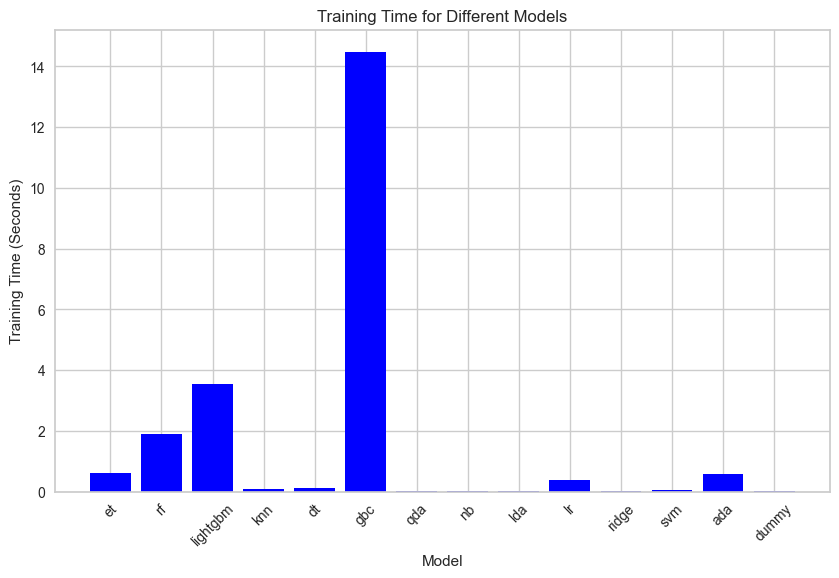

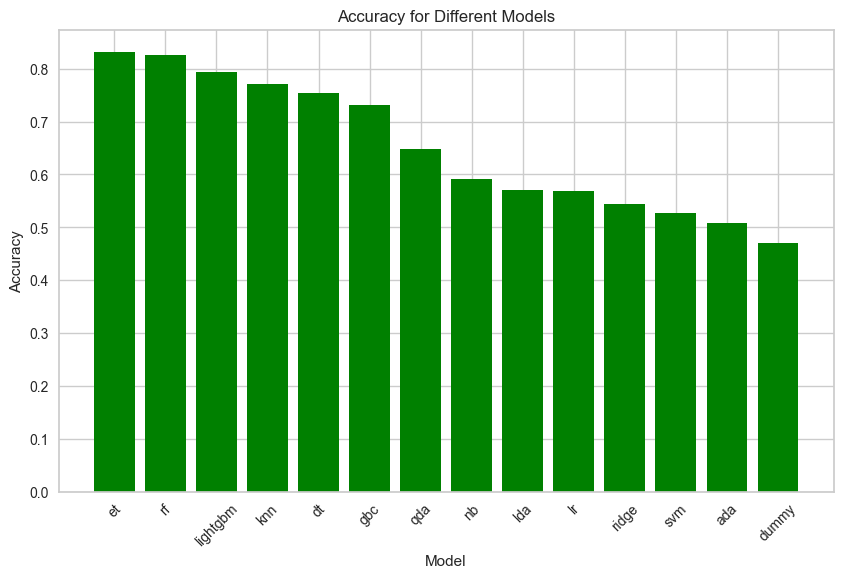

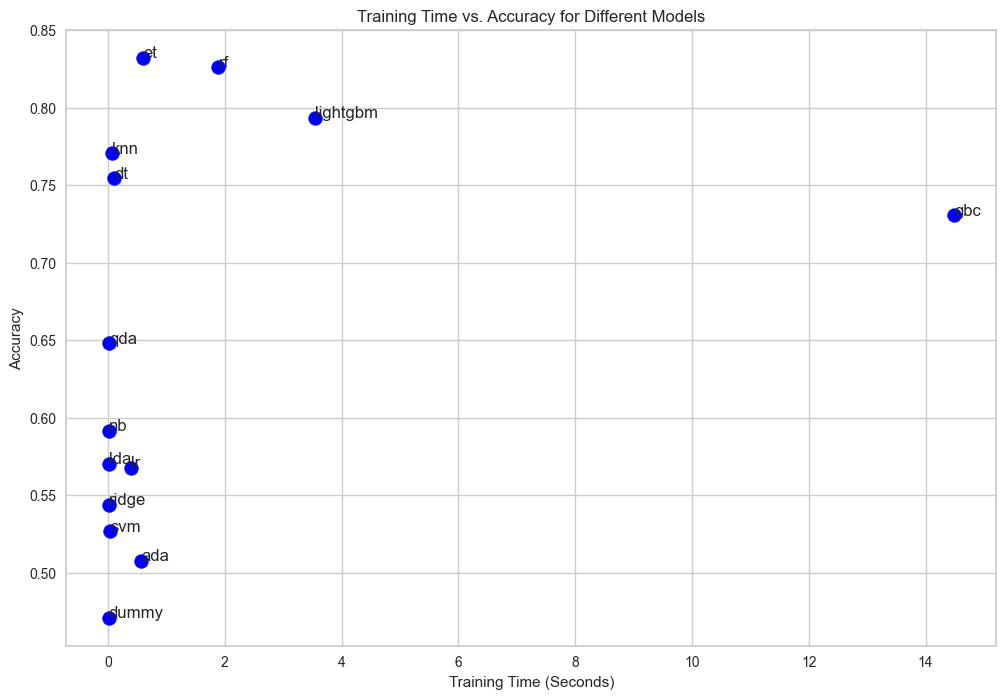

In [6]:
# Extract the results, including training time
results = pull()

# Print the results
print(results)

# Plot the training time
plt.figure(figsize=(10, 6))
plt.bar(results.index, results['TT (Sec)'], color='blue')
plt.xlabel('Model')
plt.ylabel('Training Time (Seconds)')
plt.title('Training Time for Different Models')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Plot the accuracy
plt.figure(figsize=(10, 6))
plt.bar(results.index, results['Accuracy'], color='green')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy for Different Models')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Create a scatter plot for training time vs. accuracy
plt.figure(figsize=(12, 8))
plt.scatter(results['TT (Sec)'], results['Accuracy'], color='blue', s=100)

# Annotate the points with model names
for i, model in enumerate(results.index):
    plt.annotate(model, (results['TT (Sec)'][i], results['Accuracy'][i]), fontsize=12)

plt.xlabel('Training Time (Seconds)')
plt.ylabel('Accuracy')
plt.title('Training Time vs. Accuracy for Different Models')
plt.grid(True)
plt.show()

ET and KNN are definitely the best choices if we were to do reinforcement learning. ET gives the best accuracy at a reasonable time and knn gives slightly lower accuracy but at much faster training time.